In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import sqlite3
import numpy as np
import networkx as nx
from IPython.display import display
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
from sklearn.decomposition import PCA

In [3]:
dir = os.getcwd()
genres_db_path = "dataset/genres.db"
metadata_db_path = "dataset/metadata.db"
tags_db_path = "dataset/tags.db"


In [4]:
def load_data():
    conn = sqlite3.connect(genres_db_path)
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()

    conn = sqlite3.connect(tags_db_path)
    tags_df = pd.read_sql_query("SELECT * FROM tags", conn)
    conn.close()

    conn = sqlite3.connect(metadata_db_path)
    metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)
    conn.close()

    return genres_df, tags_df, metadata_df
genres_df, tags_df, metadata_df = load_data()

# Análisis exploratorio de los datos

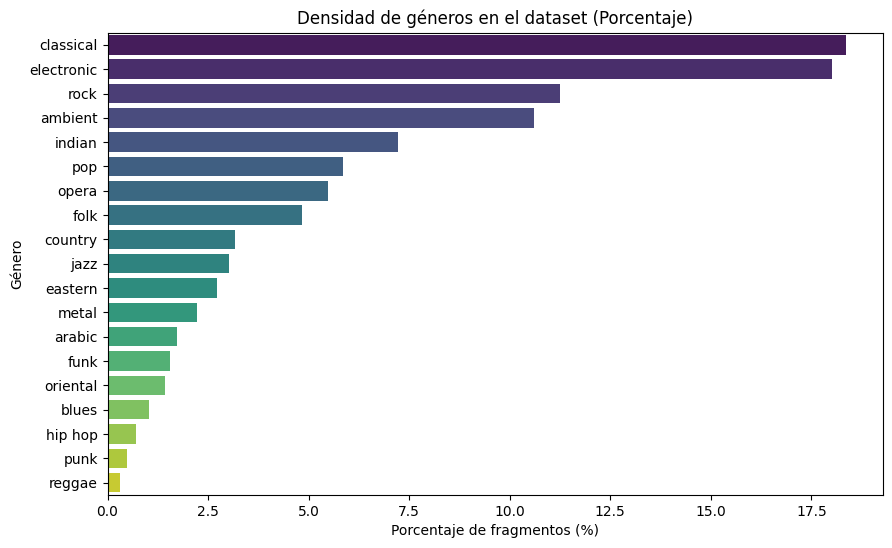

In [5]:
def visualize_density_genres(genres_df):
    """Visualiza la distribución relativa de géneros en el dataset."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])

    # Asegurarse de que todos los valores sean numéricos
    genres_df = genres_df.apply(pd.to_numeric, errors='coerce')

    genres_density = genres_df.sum(axis=0)

    total_fragments = genres_density.sum()
    genres_density = (genres_density / total_fragments) * 100

    genres_density = genres_density.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=genres_density.values,
        y=genres_density.index,
        hue=genres_density.index,
        palette="viridis",
        legend=False
    )
    plt.title("Densidad de géneros en el dataset (Porcentaje)")
    plt.xlabel("Porcentaje de fragmentos (%)")
    plt.ylabel("Género")
    plt.show()
visualize_density_genres(genres_df)

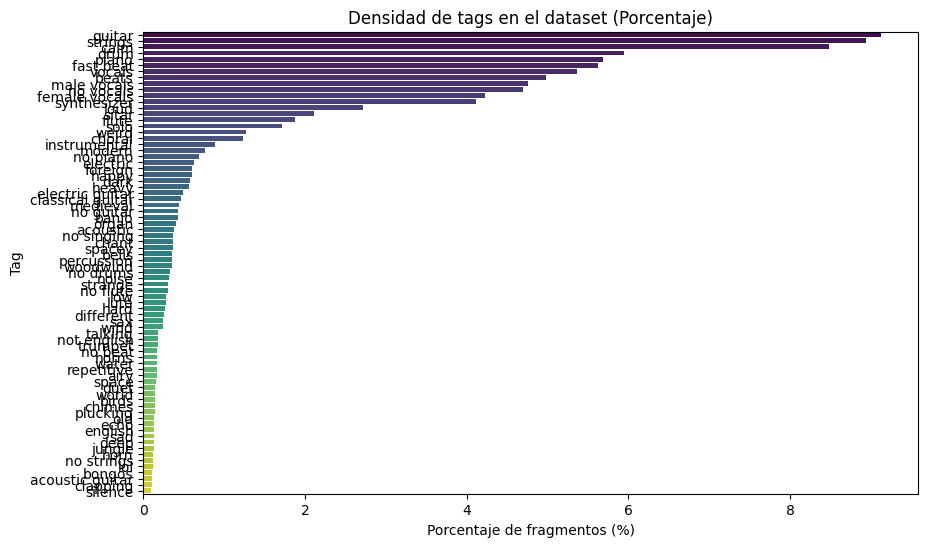

In [6]:
def visualize_density_tags(tags_df):
    """Visualiza la distribución relativa de tags en el dataset."""
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])
    tags_density = tags_df.sum(axis=0)

    total_fragments = tags_density.sum()
    tags_density = (tags_density / total_fragments) * 100
    tags_density = tags_density.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=tags_density.values, y=tags_density.index, hue=tags_density.index, palette="viridis", legend=False)
    plt.title("Densidad de tags en el dataset (Porcentaje)")
    plt.xlabel("Porcentaje de fragmentos (%)")
    plt.ylabel("Tag")
    plt.show()
visualize_density_tags(tags_df)

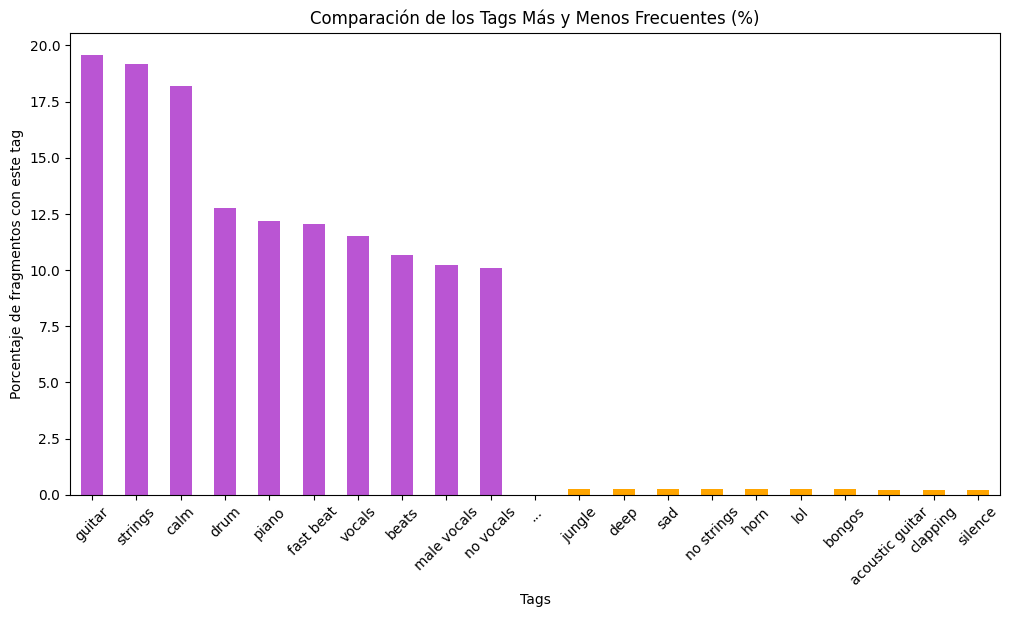

In [7]:
def visualize_stacked_bar(tags_df, top_n=10):
    """Muestra un gráfico de barras con los N tags más frecuentes a la izquierda,
    un separador en el centro y los N menos frecuentes a la derecha en orden descendente."""

    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    top_tags = tags_df.sum().sort_values(ascending=False).head(top_n).index
    top_distribution = tags_df[top_tags].sum() / tags_df.shape[0] * 100

    separator = pd.Series([np.nan], index=["..."])

    bottom_tags = tags_df.sum().sort_values(ascending=True).head(top_n).index[::-1]
    bottom_distribution = tags_df[bottom_tags].sum() / tags_df.shape[0] * 100

    full_distribution = pd.concat([top_distribution, separator, bottom_distribution])

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ["mediumorchid"] * top_n + ["gray"] + ["orange"] * top_n

    full_distribution.plot(kind="bar", color=colors, ax=ax)

    plt.title("Comparación de los Tags Más y Menos Frecuentes (%)")
    plt.xlabel("Tags")
    plt.ylabel("Porcentaje de fragmentos con este tag")
    plt.xticks(rotation=45)
    plt.show()
visualize_stacked_bar(tags_df)

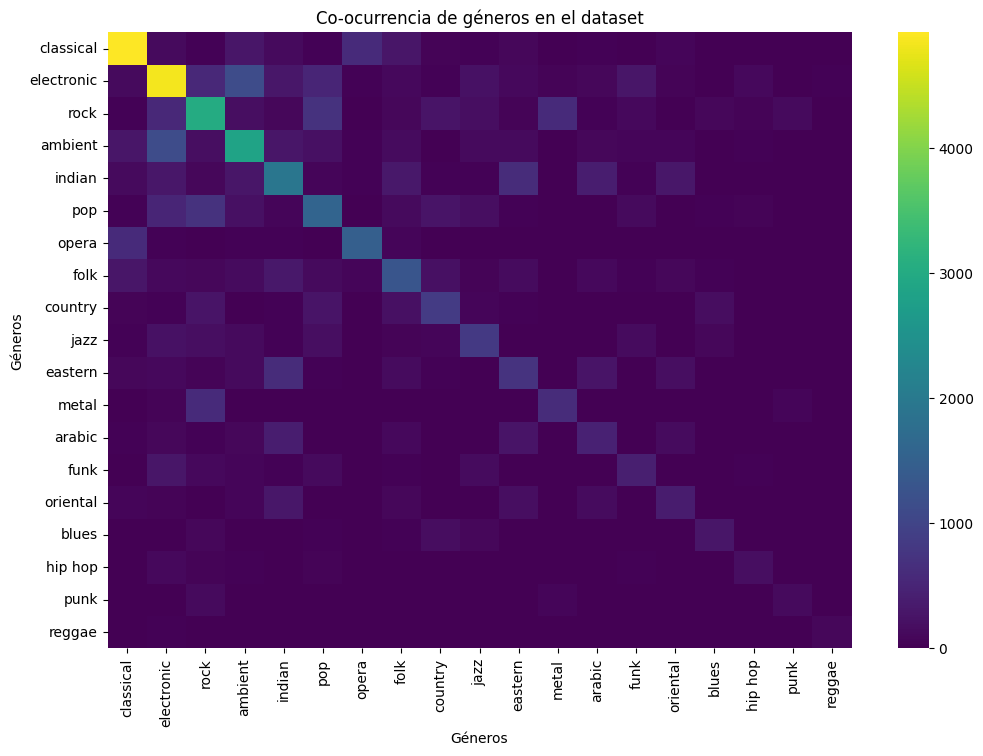

In [8]:
def visualize_genre_co_occurrence(genres_df, top_n=30):
    """Muestra una matriz de co-ocurrencia entre los géneros más frecuentes."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])

    top_genres = genres_df.sum().sort_values(ascending=False).head(top_n).index
    filtered_df = genres_df[top_genres]
    correlation_matrix = filtered_df.T.dot(filtered_df)

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap="viridis", annot=False)
    plt.title("Co-ocurrencia de géneros en el dataset")
    plt.xlabel("Géneros")
    plt.ylabel("Géneros")
    plt.show()
visualize_genre_co_occurrence(genres_df, top_n=30)

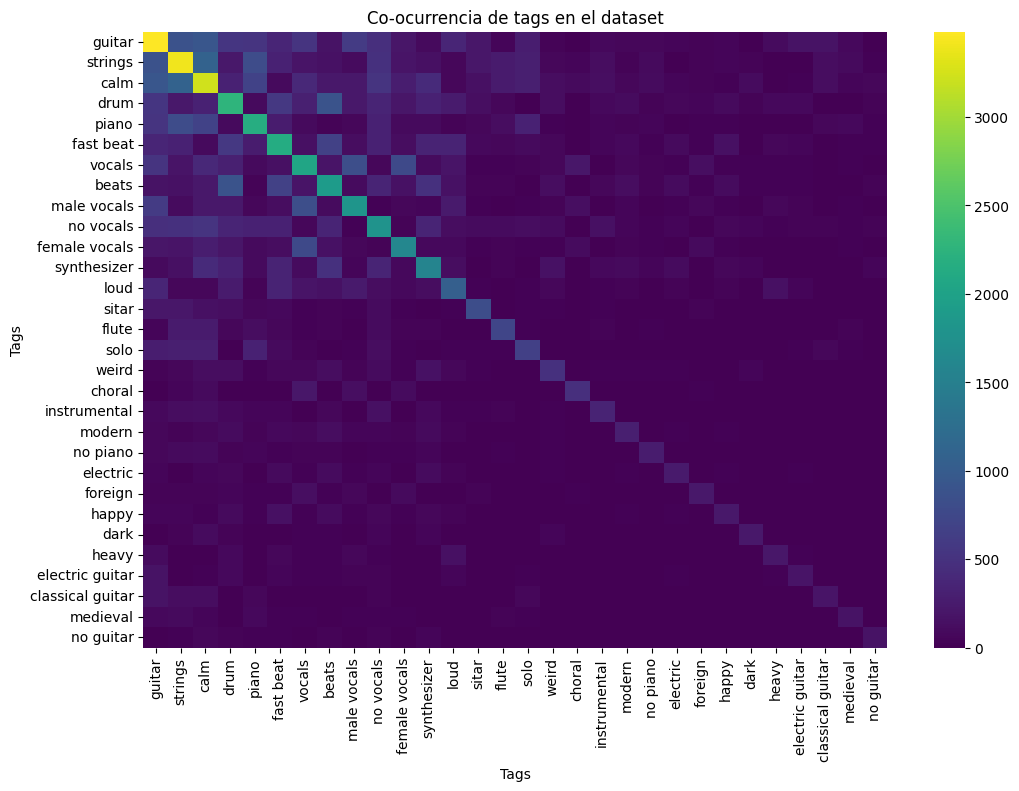

In [9]:
def visualize_tag_co_occurrence(tags_df, top_n=30):
    """Muestra una matriz de co-ocurrencia entre los tags más frecuentes."""
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    top_tags = tags_df.sum().sort_values(ascending=False).head(top_n).index
    filtered_df = tags_df[top_tags]
    correlation_matrix = filtered_df.T.dot(filtered_df)

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, cmap="viridis", annot=False)
    plt.title("Co-ocurrencia de tags en el dataset")
    plt.xlabel("Tags")
    plt.ylabel("Tags")
    plt.show()
visualize_tag_co_occurrence(tags_df)

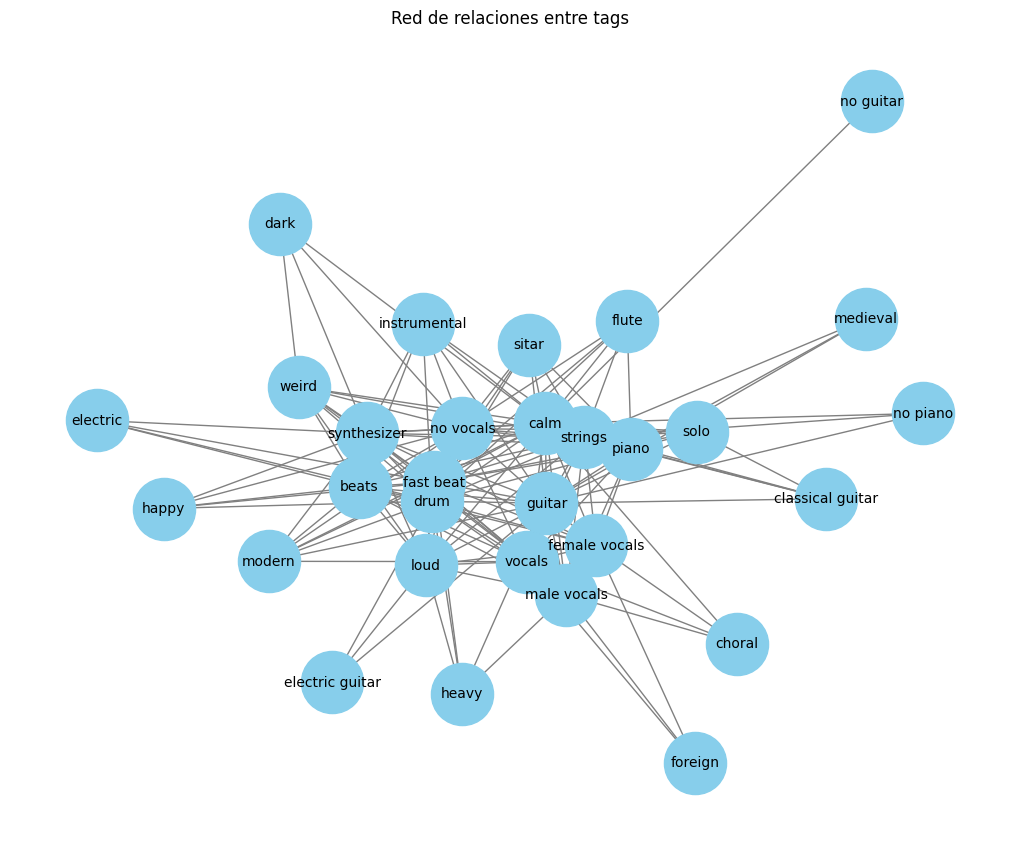

In [10]:
def visualize_tag_network(tags_df, top_n=30):
    """Genera una red de relaciones entre los tags más comunes."""
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])
    top_tags = tags_df.sum().sort_values(ascending=False).head(top_n).index
    filtered_df = tags_df[top_tags]

    G = nx.Graph()
    WEIGHT_THRESHOLD = 50

    for tag1 in top_tags:
        for tag2 in top_tags:
            if tag1 != tag2:
                weight = (filtered_df[tag1] & filtered_df[tag2]).sum()
                if weight > WEIGHT_THRESHOLD:
                    G.add_edge(tag1, tag2, weight=weight)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    edges = G.edges(data=True)
    nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=2000, font_size=10)
    plt.title("Red de relaciones entre tags")
    plt.show()
visualize_tag_network(tags_df, top_n=30)

# Análisis estadístico

### Correlación entre variables

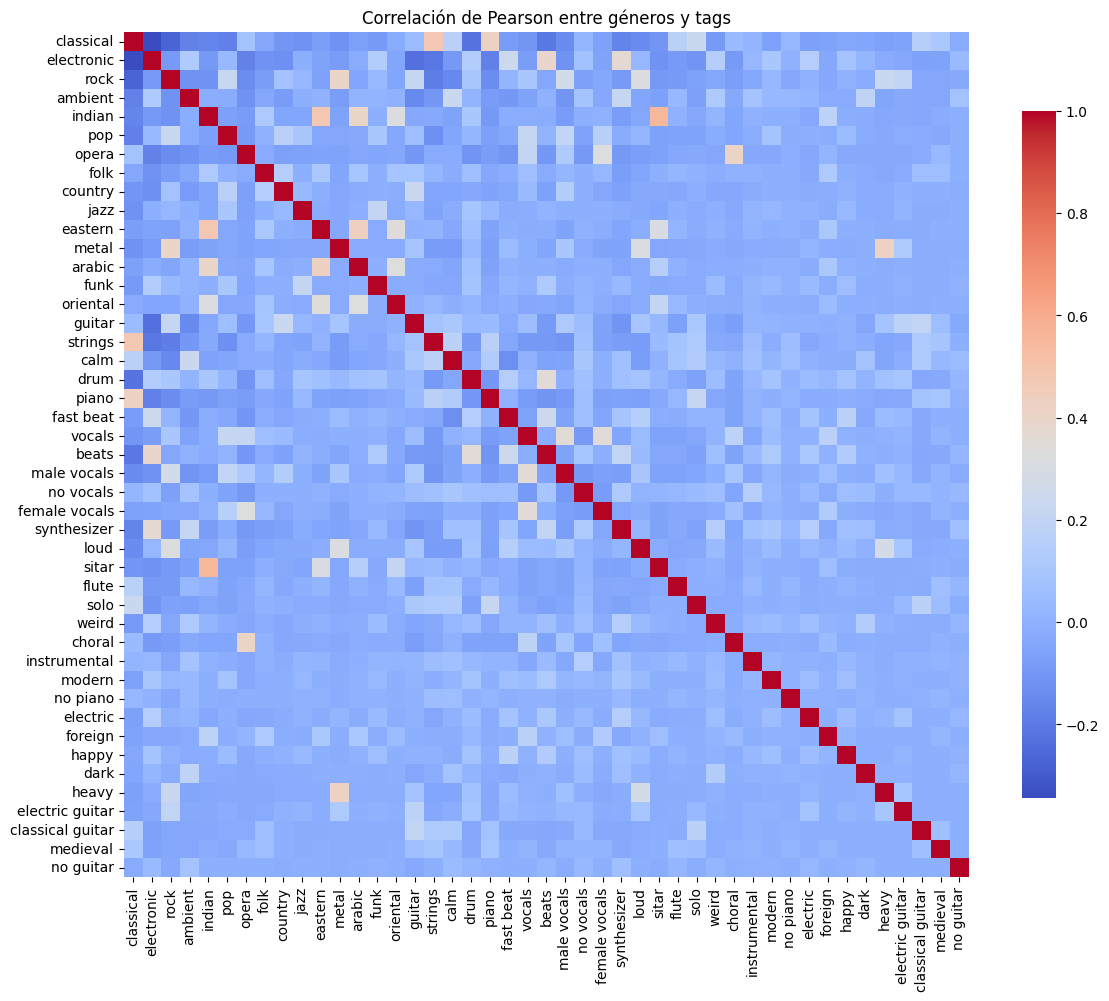

In [15]:
def visualize_pearson_correlation(genres_df, tags_df, n=15, m=30):
    """Visualiza la correlación de Pearson entre los géneros y los tags más frecuentes."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    top_genres = genres_df.sum().sort_values(ascending=False).head(n).index
    top_tags = tags_df.sum().sort_values(ascending=False).head(m).index

    filtered_genres = genres_df[top_genres]
    filtered_tags = tags_df[top_tags]

    merged_df = pd.concat([filtered_genres, filtered_tags], axis=1)
    correlation_matrix = merged_df.corr(method='pearson')

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, square=True, cbar_kws={"shrink": .8})
    plt.title("Correlación de Pearson entre géneros y tags")
    plt.tight_layout()
visualize_pearson_correlation(genres_df, tags_df, n=15, m=30)

In [ ]:
def visualize_pearson_correlation_dataframe(genres_df, tags_df):
    """Visualiza la correlación de Pearson entre géneros y tags."""
    genres_df = genres_df.drop(columns=["clip_id", "mp3_path"])
    tags_df = tags_df.drop(columns=["clip_id", "mp3_path"])

    merged_df = pd.concat([genres_df, tags_df], axis=1)
    correlation_matrix = merged_df.corr(method='pearson')


    display(correlation_matrix)
visualize_pearson_correlation_dataframe(genres_df, tags_df)

,classical,jazz,folk,ambient,electronic,opera,country,funk,arabic,eastern,...,electric,no strings,no piano,no beat,no singing,no guitar,no vocals,no flute,no drums,not english
classical,1.000000,-0.117216,-0.042217,-0.176291,-0.344653,0.078044,-0.107234,-0.088613,-0.070834,-0.075882,...,-0.069229,-0.004905,0.027298,-0.012941,0.013718,-0.029422,0.021802,0.024350,0.021691,-0.019223
jazz,-0.117216,1.000000,-0.008607,-0.007280,-0.004460,-0.061775,0.034406,0.211108,-0.006866,-0.019411,...,0.006979,-0.000767,-0.001957,-0.013351,0.013669,-0.007013,-0.004318,-0.007444,-0.015179,-0.013849
folk,-0.042217,-0.008607,1.000000,-0.035263,-0.116406,-0.025460,0.143904,-0.009413,0.095638,0.107627,...,-0.031034,-0.010242,-0.012589,-0.010026,0.013664,-0.008997,-0.004954,-0.006302,0.002248,0.078181
ambient,-0.176291,-0.007280,-0.035263,1.000000,0.124502,-0.113790,-0.086925,0.009068,0.007961,0.003382,...,0.012529,0.037289,0.029910,0.086881,-0.002961,0.078251,0.083218,0.011074,0.040397,-0.017901
electronic,-0.344653,-0.004460,-0.116406,0.124502,1.000000,-0.173630,-0.124790,0.133640,-0.023164,-0.059212,...,0.143932,0.032624,-0.002697,0.006424,0.012026,0.040341,0.075484,-0.003070,0.009199,-0.018586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
no guitar,-0.029422,-0.007013,-0.008997,0.078251,0.040341,-0.005480,-0.016084,0.000527,-0.004633,-0.005112,...,0.024307,0.006492,-0.006851,-0.005889,0.024393,1.000000,0.028286,-0.000378,0.013007,-0.006108
no vocals,0.021802,-0.004318,-0.004954,0.083218,0.075484,-0.093067,-0.011875,0.012042,-0.013466,0.006160,...,0.038314,0.015514,-0.006537,0.028721,0.127384,0.028286,1.000000,-0.005823,0.003139,-0.021195
no flute,0.024350,-0.007444,-0.006302,0.011074,-0.003070,-0.008774,-0.004767,-0.003187,-0.008670,-0.002393,...,-0.009415,-0.004135,-0.009784,0.006685,0.000710,-0.000378,-0.005823,1.000000,0.018543,0.006088
no drums,0.021691,-0.015179,0.002248,0.040397,0.009199,-0.003274,0.000102,-0.008632,-0.013726,0.016552,...,0.007603,-0.004331,-0.010249,0.005934,0.000014,0.013007,0.003139,0.018543,1.000000,-0.005327
